In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path
import platform

# Comment here to add in for either mac or linux computer
if platform.system() == "Linux":   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
elif platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])
elif platform.system() == "Windows":
    print('No windows repositories defined')

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.utils.signal_process import WaveletSg
from neuropy.plotting.spikes import plot_raster, plot_binned_raster
from neuropy.plotting.signals import plot_signal_w_epochs, plot_spectrogram

from tracefc.io.session_directory import get_session_dir

In [2]:
# Define a class for a typical recording or set of recordings
from neuropy.core.session import ProcessData
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
animal, sess_name = 'Jyn', 'training'
sess_dir = get_session_dir(animal, sess_name)
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/Jyn_training_denoised.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 17071.19 seconds 
duration: 4.74 hours 



# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [5]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.25  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    # art_epochs = detect_artifact_epochs(signal, thresh=8, 
    #                                 edge_cutoff=3, merge=6)

    # Pick a particular channel with the code below
    art_epochs = detect_artifact_epochs(signal.time_slice(channel_id=26), thresh=8, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)

print(f'Total artifact time = {art_epochs.durations.sum():0.1F} seconds')
art_epochs.to_dataframe()

Existing artifact epochs file loaded
Total artifact time = 108.6 seconds


/home/bowenw/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


,start,stop,label,duration
0,868.3664,870.7752,,2.4088
1,1160.5312,1162.5560,,2.0248
2,1432.4056,1435.9024,,3.4968
3,1711.3776,1713.6968,,2.3192
4,1971.0752,1973.5232,,2.4480
5,1999.2224,2001.6896,,2.4672
6,2261.2112,2263.2896,,2.0784
7,2633.3672,2634.5616,,1.1944
8,7090.3376,7102.0696,,11.7320
9,7259.5000,7273.8224,,14.3224


<Axes: >

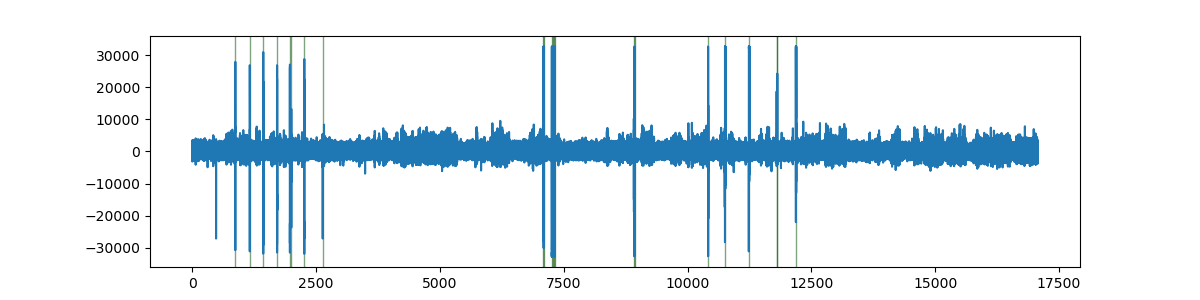

In [6]:
%matplotlib widget

chan_plot = 25
plot_signal_w_epochs(signal, chan_plot, art_epochs)

## Define probe group

/data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/Jyn_training_denoised.probegroup.npy saved


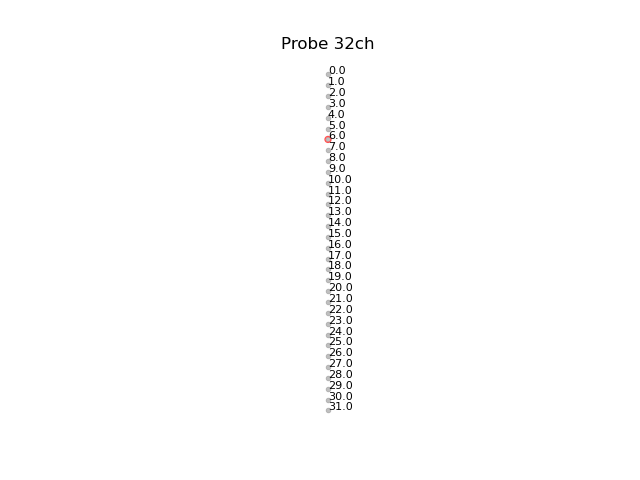

In [7]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=50, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

# Detect Theta epochs

In [8]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=1
maxdur=20
thresh = (1, None)
sigma = 0.125
edge_cutoff = 0.20
theta_channel = 18

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
sess.recinfo.write_epochs(theta_epochs, ext='tha')
theta_epochs_file = sess.filePrefix.with_suffix(".theta_epochs.npy")
theta_epochs.save(theta_epochs_file)

Best channel for theta: [18]
873 epochs remaining with durations within (1,20)
/data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/Jyn_training_denoised.theta_epochs.npy saved


In [9]:
theta_epochs.metadata

{'params': {'lowThres': 1,
  'highThresh': None,
  'freq_band': (5, 12),
  'mindur': 1,
  'maxdur': 20},
 'channels': [18]}

<Axes: >

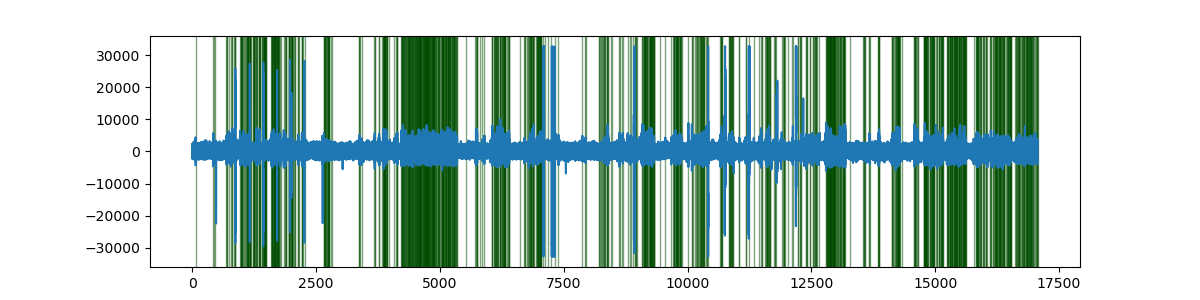

In [10]:
%matplotlib widget

chan_plot = theta_channel
plot_signal_w_epochs(signal, chan_plot, theta_epochs)

(-4000.0, 4000.0)

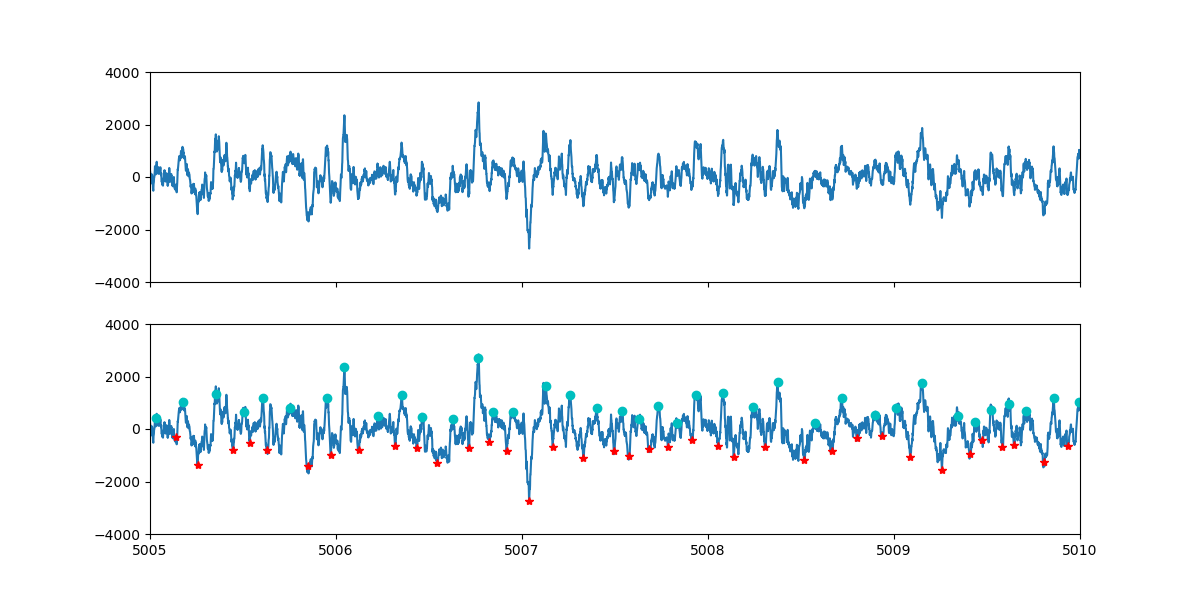

In [11]:
from neuropy.utils.signal_process import hilbert_amplitude_stat, theta_phase_specfic_extraction, ThetaParams
tparams = ThetaParams(lfp=signal.traces[theta_channel, :], fs=signal.sampling_rate, method="waveshape")
trough_indices = tparams.trough.astype(int)
peak_indices = tparams.peak.astype(int)
_, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True, sharey=True)
plot_signal_w_epochs(signal, chan_plot, theta_epochs, ax=ax[0])
ax[1].plot(signal.time, signal.traces[theta_channel])

ax[1].plot(signal.time[trough_indices], signal.traces[theta_channel, trough_indices], 'r*')
ax[1].plot(signal.time[peak_indices], signal.traces[theta_channel, peak_indices], 'co')

ax[0].set_xlim((5005, 5010))
ax[1].set_ylim((-4000, 4000))

(-4000.0, 4000.0)

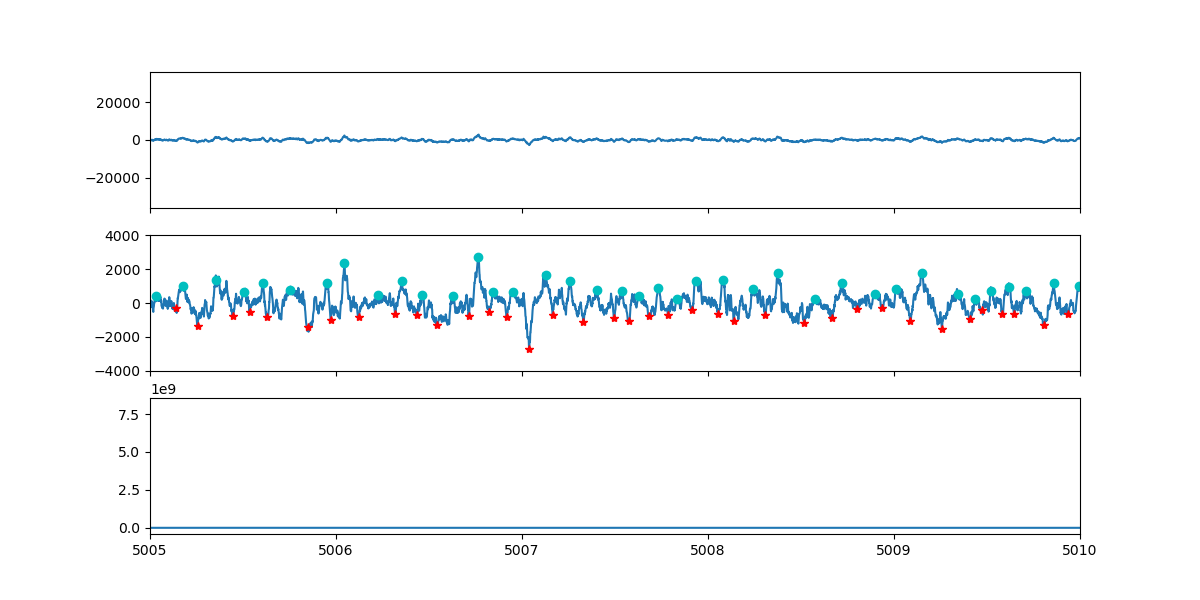

In [12]:
_, ax = plt.subplots(3, 1, figsize=(12, 6), sharex=True, sharey=False)
plot_signal_w_epochs(signal, chan_plot, theta_epochs, ax=ax[0])
ax[1].plot(signal.time, signal.traces[theta_channel])

ax[1].plot(signal.time[trough_indices], signal.traces[theta_channel, trough_indices], 'r*')
ax[1].plot(signal.time[peak_indices], signal.traces[theta_channel, peak_indices], 'co')

ax[2].plot(signal.time, tparams.amp)

ax[0].set_xlim((5005, 5010))
ax[1].set_ylim((-4000, 4000))

In [13]:
# Import USV epochs (from Sync_USV_and_Ephys notebook).
usv_epochs_file = sess.filePrefix.with_suffix(".usv_epochs.npy")
usv_epochs = Epoch(epochs=None, file=usv_epochs_file)
usv_epochs


16 epochs
Snippet: 
         start        stop  Begin_Time   Freq_Min  Duration  Freq_Range  Score  \
0  870.126212  870.171338  505.926529  47.944444  0.045134   27.777778    1.0   
1  871.160586  871.233890  506.961084  45.345779  0.073317   25.343152    1.0   
2  871.556279  871.597182  507.356846  50.209416  0.040911    5.905844    1.0   
3  871.961179  872.056770  507.761818  46.842283  0.095608    5.095238    1.0   
4  872.405570  872.475605  508.206287  45.924784  0.070048    5.326840    1.0   

   Accept label  
0       1        
1       1        
2       1        
3       1        
4       1        

In [14]:
lowusv_epochs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min<=23]
lowusv_epochs

,start,stop,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept,label


## all USV Theta phase plots

<Axes: ylabel='Count'>

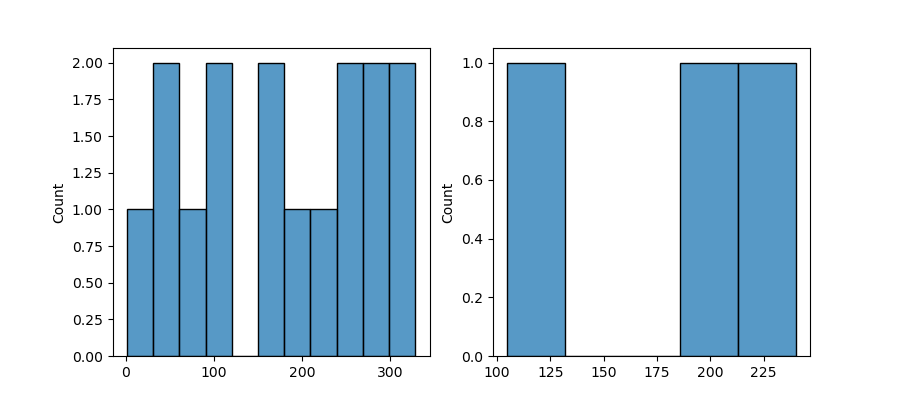

In [15]:
# First get frame number of each usv.
usv_start_frames = (usv_epochs.starts * tparams.fs).astype(int)
usv_start_frames

# Get theta power for each call start
# high_theta_usv_start_times = theta_epochs.contains(usv_epochs.starts)  # This might be too conservative
usv_start_theta_power = theta_power[usv_start_frames]

# Only include calls with above average theta power
theta_thresh = 0  # units = std (theta power is z-scored)
high_usv_power_bool = usv_start_theta_power > theta_thresh
high_theta_usv_start_frames = usv_start_frames[high_usv_power_bool]

# Next, calculate theta phase angle at each usv start
phase_start = tparams.angle[usv_start_frames]
high_theta_phase_start = tparams.angle[high_theta_usv_start_frames]

# Plot histogram of usv start angles
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.histplot(phase_start, binwidth=30, ax=ax[0])
sns.histplot(high_theta_phase_start, binwidth=30, ax=ax[1])

In [16]:
usv_start_frames[high_usv_power_bool]

array([1091975, 1093426, 1104907])

In [17]:
high_usv_power_bool

array([False, False, False, False, False, False, False,  True, False,
       False,  True, False, False, False, False,  True])

## high/low USV and theta epoch plot

/tmp/ipykernel_1465473/3395203564.py:18: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.6), duration, 0.4, color='blue', edgecolor='none', alpha=0.5)
/tmp/ipykernel_1465473/3395203564.py:23: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((start_time, 0.1), duration, 0.4, color='green', edgecolor='none', alpha=0.5)


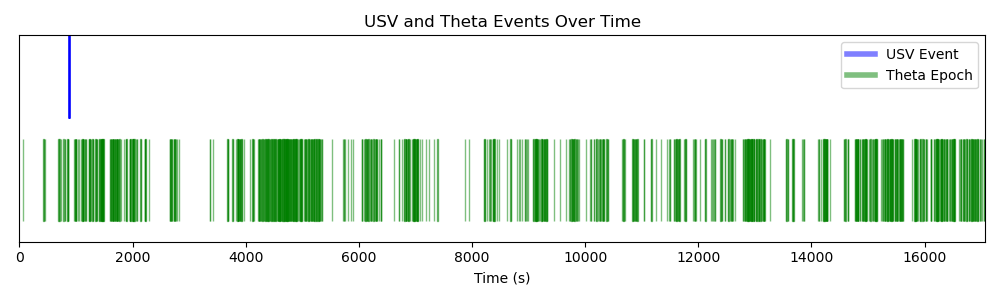

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

usv_start_times = usv_epochs.starts 
usv_stop_times = usv_epochs.stops  
usv_durations = usv_epochs.stops-usv_epochs.starts  

theta_start_times = theta_epochs.starts  
theta_stop_times = theta_epochs.stops  
theta_durations = theta_stop_times - theta_start_times 

fig, ax = plt.subplots(figsize=(10, 3))  

# Plot USV events
for start_time, duration in zip(usv_start_times, usv_durations):
    rect = Rectangle((start_time, 0.6), duration, 0.4, color='blue', edgecolor='none', alpha=0.5)
    ax.add_patch(rect)

# Plot Theta epochs
for start_time, duration in zip(theta_start_times, theta_durations):
    rect = Rectangle((start_time, 0.1), duration, 0.4, color='green', edgecolor='none', alpha=0.5)
    ax.add_patch(rect)


from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='blue', lw=4, alpha=0.5), Line2D([0], [0], color='green', lw=4, alpha=0.5)]
ax.legend(custom_lines, ['USV Event', 'Theta Epoch'])

ax.set_xlim(0, max(np.max(usv_stop_times), np.max(theta_stop_times)) + 1)
ax.set_ylim(0, 1)
ax.set_xlabel('Time (s)')
ax.set_yticks([])
plt.title('USV and Theta Events Over Time')
plt.tight_layout()
plt.show()

In [19]:
theta_epochs

873 epochs
Snippet: 
       start      stop  peak_time  peak_power label
0   67.3376   70.5680    68.6544    4.956332      
1  419.7584  426.7304   421.5552    5.349023      
2  439.8848  441.0288   440.5144    1.044431      
3  455.9128  457.1640   456.5064    1.288376      
4  689.2384  692.2480   691.2208    5.678269      

In [20]:
from neuropy.utils.ccg import correlograms


theta_off_usv_on_times = [theta_epochs.stops, usv_epochs.starts]
theta_off_usv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_usv_on_times)])
theta_off_usv_on_times = np.hstack(theta_off_usv_on_times)
sort_ids = np.argsort(theta_off_usv_on_times)

theta_off_usv_on_times = theta_off_usv_on_times[sort_ids]
theta_off_usv_on_ids = theta_off_usv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_usv_on_times, theta_off_usv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)

In [21]:
theta_off_usv_on_times

array([   70.568     ,   426.7304    ,   441.0288    ,   457.164     ,
         692.248     ,   711.0576    ,   735.0184    ,   782.4632    ,
         804.4456    ,   810.5632    ,   851.7712    ,   855.8       ,
         857.6752    ,   862.016     ,   870.12621214,   871.16058558,
         871.55627853,   871.96117907,   872.40556962,   872.62320442,
         873.30358294,   873.58048455,   873.8519481 ,   874.08838145,
         874.74085262,   875.73368129,   876.2977828 ,   879.14386165,
         879.36471765,   883.92618859,   969.864     ,   978.12      ,
         985.5568    ,   990.6776    ,   993.64      ,   999.864     ,
        1004.6528    ,  1008.62      ,  1034.0616    ,  1055.076     ,
        1096.0992    ,  1107.6424    ,  1114.9112    ,  1120.0128    ,
        1124.5088    ,  1128.412     ,  1130.3632    ,  1134.6976    ,
        1157.36      ,  1160.472     ,  1170.0512    ,  1176.8424    ,
        1229.3376    ,  1235.2376    ,  1238.6904    ,  1247.592     ,
      

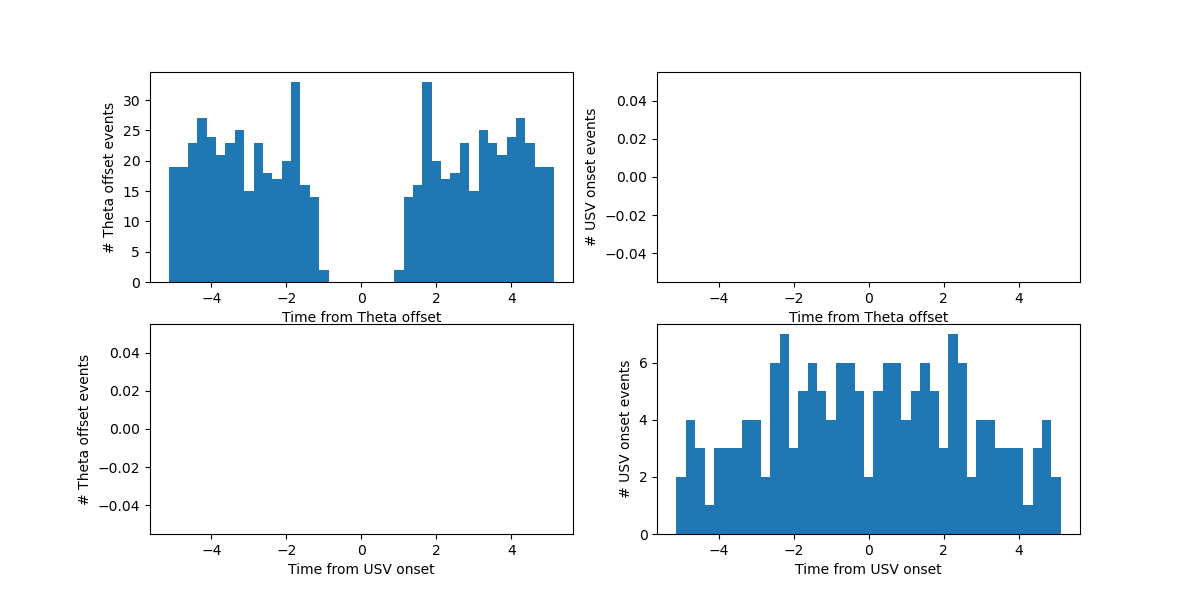

In [22]:
# # Sample plotting code
# time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
# _, ax = plt.subplots(2, 2, figsize=(12, 6))

# var_names = ['Theta offset', 'USV onset']
# for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
#     for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
#         a2.bar(time_bins, ccg_use2, width=bin_size)
#         a2.set_xlabel(f"Time from {var_names[idv]}")
#         a2.set_ylabel(f"# {var_names[ida2]} events")

In [23]:
usv_epochs._epochs

,start,stop,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept,label
0,870.126212,870.171338,505.926529,47.944444,0.045134,27.777778,1.000000,1,
1,871.160586,871.233890,506.961084,45.345779,0.073317,25.343152,1.000000,1,
2,871.556279,871.597182,507.356846,50.209416,0.040911,5.905844,1.000000,1,
3,871.961179,872.056770,507.761818,46.842283,0.095608,5.095238,1.000000,1,
4,872.405570,872.475605,508.206287,45.924784,0.070048,5.326840,1.000000,1,
5,872.623204,872.696609,508.423960,42.557651,0.073417,27.213203,1.000000,1,
6,873.303583,873.349983,509.104458,38.860931,0.046408,29.645022,1.000000,1,
7,873.580485,873.676931,509.381408,42.366841,0.096464,7.597611,0.544231,1,
8,873.851948,873.887906,509.652919,37.355519,0.035965,29.521707,1.000000,1,
9,874.088381,874.238507,509.889394,43.608766,0.150152,8.221861,0.544231,1,


# Ripple detection

In [24]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 18
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
exclude_theta_epochs = False  # make this true if you end up with a lot of false positive ripples as gamma events during theta

if not exclude_theta_epochs:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs)
else:
    ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff,
                                         ignore_epochs=art_epochs.__add__(theta_epochs))
sess.recinfo.write_epochs(ripple_epochs, ext='swr')
ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
ripple_epochs.save(ripple_epochs_file)

Selected channels for ripples: [18]
9030 epochs remaining with durations within (0.05,0.45)
/data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/Jyn_training_denoised.ripple_epochs.npy saved


In [25]:
usv_epochs._epochs.Duration.mean()

0.07507296337757197

In [26]:
short_usv_epochs = usv_epochs._epochs[usv_epochs._epochs.Duration<0.1]
short_usv_epochs

,start,stop,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept,label
0,870.126212,870.171338,505.926529,47.944444,0.045134,27.777778,1.000000,1,
1,871.160586,871.233890,506.961084,45.345779,0.073317,25.343152,1.000000,1,
2,871.556279,871.597182,507.356846,50.209416,0.040911,5.905844,1.000000,1,
3,871.961179,872.056770,507.761818,46.842283,0.095608,5.095238,1.000000,1,
4,872.405570,872.475605,508.206287,45.924784,0.070048,5.326840,1.000000,1,
5,872.623204,872.696609,508.423960,42.557651,0.073417,27.213203,1.000000,1,
6,873.303583,873.349983,509.104458,38.860931,0.046408,29.645022,1.000000,1,
7,873.580485,873.676931,509.381408,42.366841,0.096464,7.597611,0.544231,1,
8,873.851948,873.887906,509.652919,37.355519,0.035965,29.521707,1.000000,1,
10,874.740853,874.810992,510.541979,38.875000,0.070152,14.461039,0.544231,1,


In [27]:
long_usv_epochs_filtered = usv_epochs._epochs[(usv_epochs._epochs.Duration>0.1)]
long_usv_epochs_filtered

,start,stop,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept,label
9,874.088381,874.238507,509.889394,43.608766,0.150152,8.221861,0.544231,1,
14,879.364718,879.534670,515.166656,41.770022,0.169982,9.365801,0.544231,1,


In [28]:
highusv_epochs = usv_epochs._epochs[usv_epochs._epochs.Freq_Min>23]
highusv_epochs

,start,stop,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept,label
0,870.126212,870.171338,505.926529,47.944444,0.045134,27.777778,1.000000,1,
1,871.160586,871.233890,506.961084,45.345779,0.073317,25.343152,1.000000,1,
2,871.556279,871.597182,507.356846,50.209416,0.040911,5.905844,1.000000,1,
3,871.961179,872.056770,507.761818,46.842283,0.095608,5.095238,1.000000,1,
4,872.405570,872.475605,508.206287,45.924784,0.070048,5.326840,1.000000,1,
5,872.623204,872.696609,508.423960,42.557651,0.073417,27.213203,1.000000,1,
6,873.303583,873.349983,509.104458,38.860931,0.046408,29.645022,1.000000,1,
7,873.580485,873.676931,509.381408,42.366841,0.096464,7.597611,0.544231,1,
8,873.851948,873.887906,509.652919,37.355519,0.035965,29.521707,1.000000,1,
9,874.088381,874.238507,509.889394,43.608766,0.150152,8.221861,0.544231,1,


## All theta CCG plots

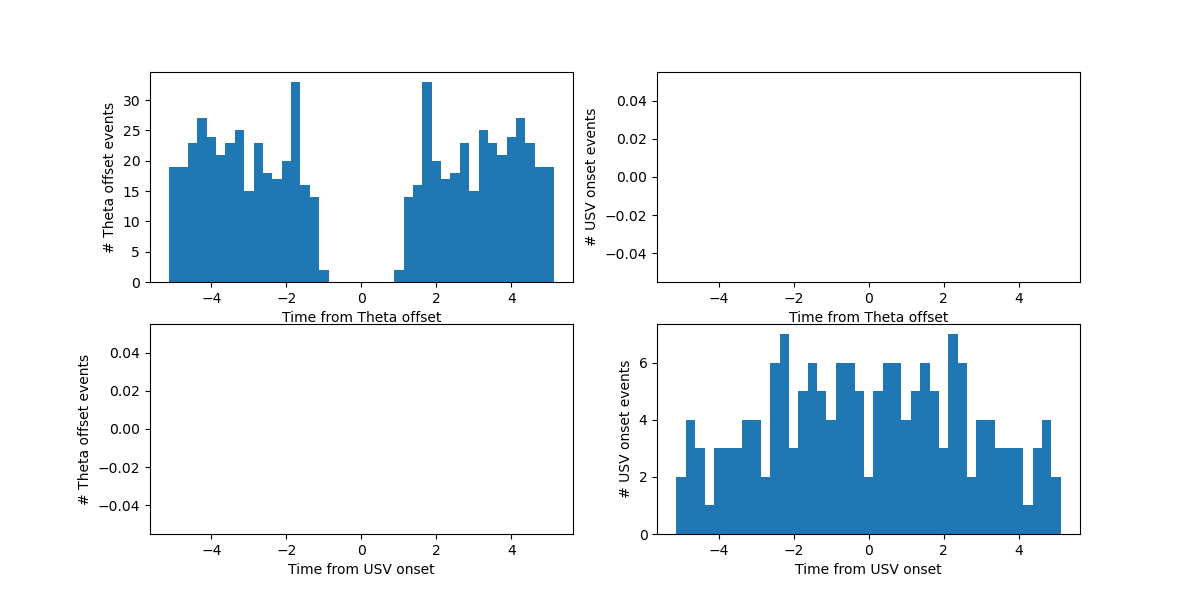

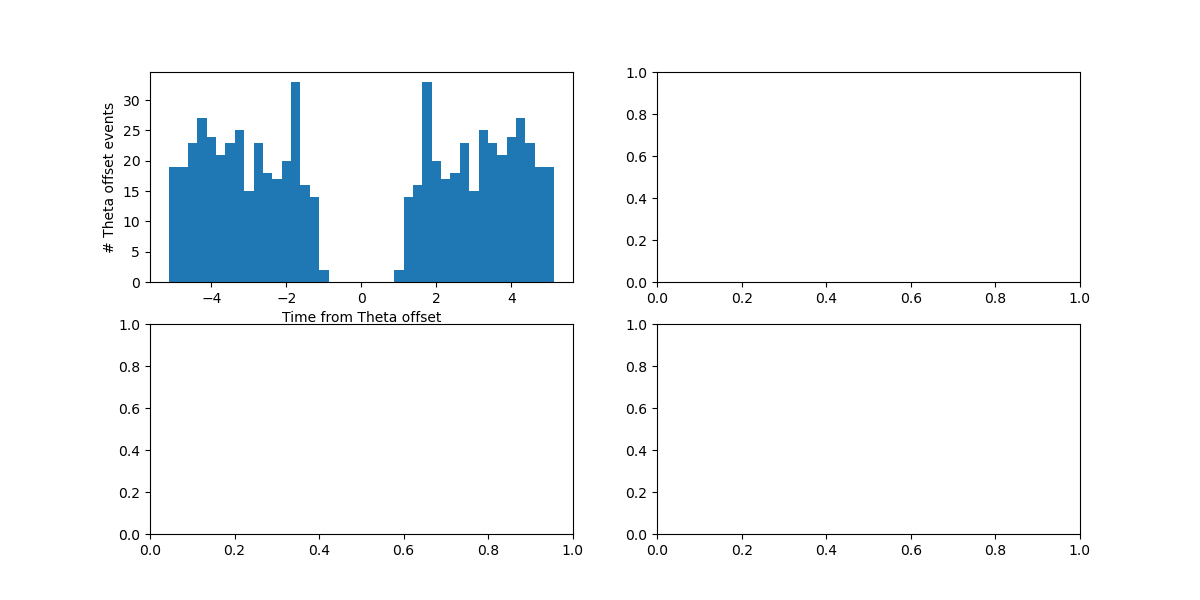

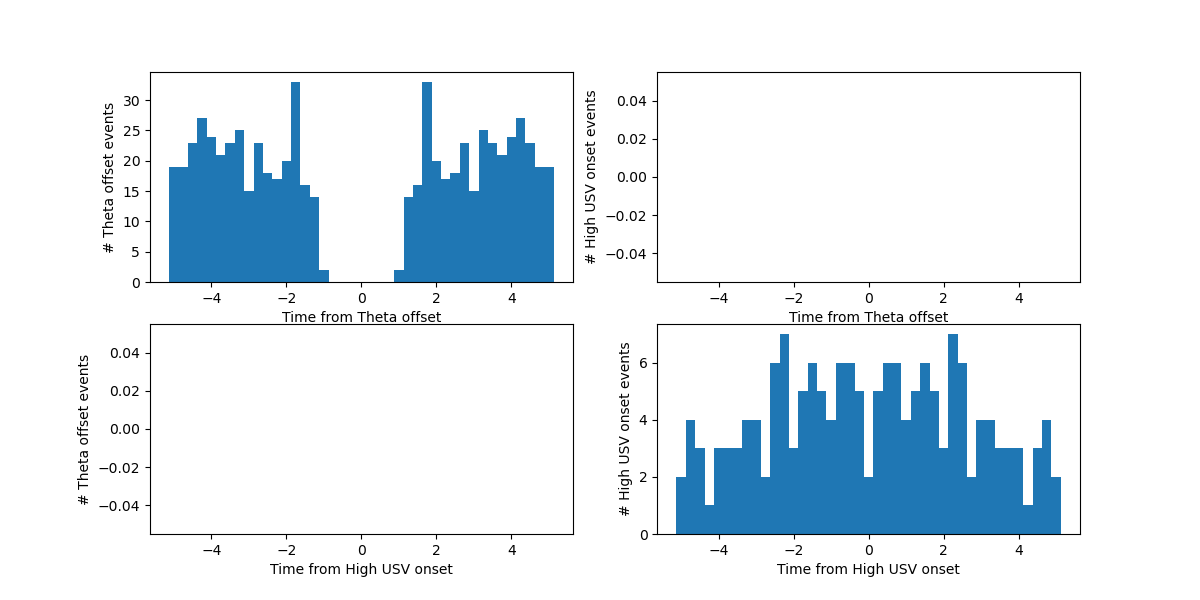

In [29]:
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_usv_on_times = [theta_epochs.stops, usv_epochs.starts]
theta_off_usv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_usv_on_times)])
theta_off_usv_on_times = np.hstack(theta_off_usv_on_times)
sort_ids = np.argsort(theta_off_usv_on_times)

theta_off_usv_on_times = theta_off_usv_on_times[sort_ids]
theta_off_usv_on_ids = theta_off_usv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_usv_on_times, theta_off_usv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr1_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['Theta offset', 'USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")

corr1_fig.savefig('/home/bowenw/Documents/thesisplots/Jyn usv-theta ccg all.png')

#low usv
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_lowusv_on_times = [theta_epochs.stops, lowusv_epochs.start]
theta_off_lowusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_lowusv_on_times)])
theta_off_lowusv_on_times = np.hstack(theta_off_lowusv_on_times)
sort_ids = np.argsort(theta_off_lowusv_on_times)

theta_off_lowusv_on_times = theta_off_lowusv_on_times[sort_ids]
theta_off_lowusv_on_ids = theta_off_lowusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_lowusv_on_times, theta_off_lowusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr2_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['Theta offset', 'Low USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")

corr2_fig.savefig('/home/bowenw/Documents/thesisplots/Jyn usv-theta ccg lowusv.png')

#high usv
from neuropy.utils.ccg import correlograms

# We observe that right after theta ends there seem to be a lot of USVs starting - check this by looking at CCG between theta off and
# USV onset times
theta_off_highusv_on_times = [theta_epochs.stops, highusv_epochs.start]
theta_off_highusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(theta_off_highusv_on_times)])
theta_off_highusv_on_times = np.hstack(theta_off_highusv_on_times)
sort_ids = np.argsort(theta_off_highusv_on_times)

theta_off_highusv_on_times = theta_off_highusv_on_times[sort_ids]
theta_off_highusv_on_ids = theta_off_highusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.25 # seconds
ccg = correlograms(theta_off_highusv_on_times, theta_off_highusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr3_fig, ax = plt.subplots(2, 2, figsize=(12, 6))


var_names = ['Theta offset', 'High USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
corr3_fig.savefig('/home/bowenw/Documents/thesisplots/Jyn usv-theta ccg highusv.png')

## All ripple CCG plots

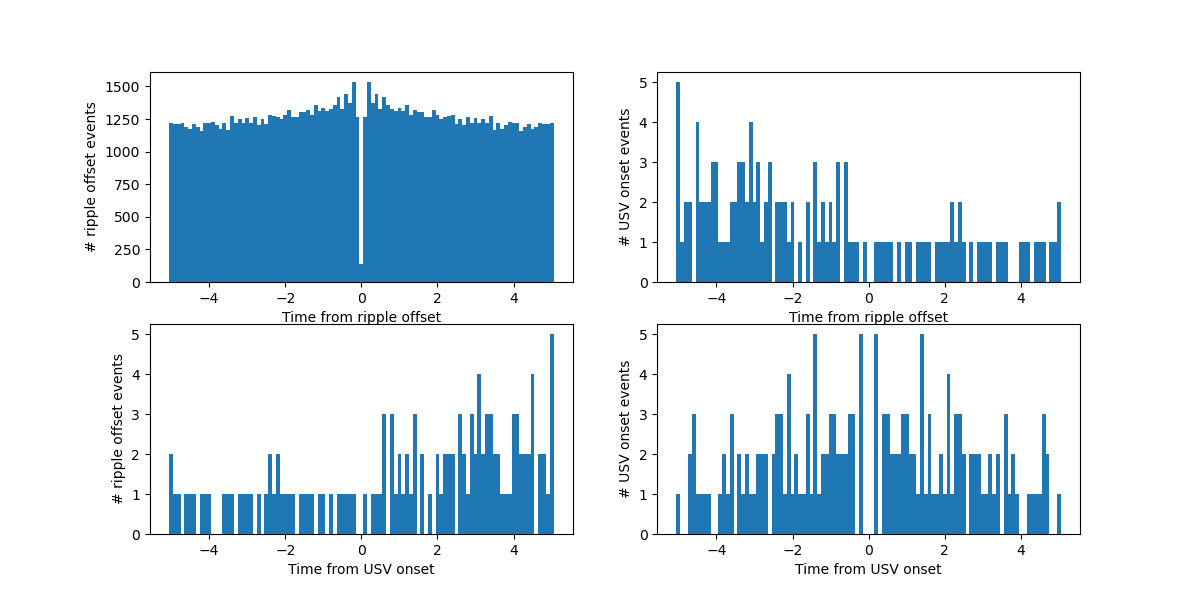

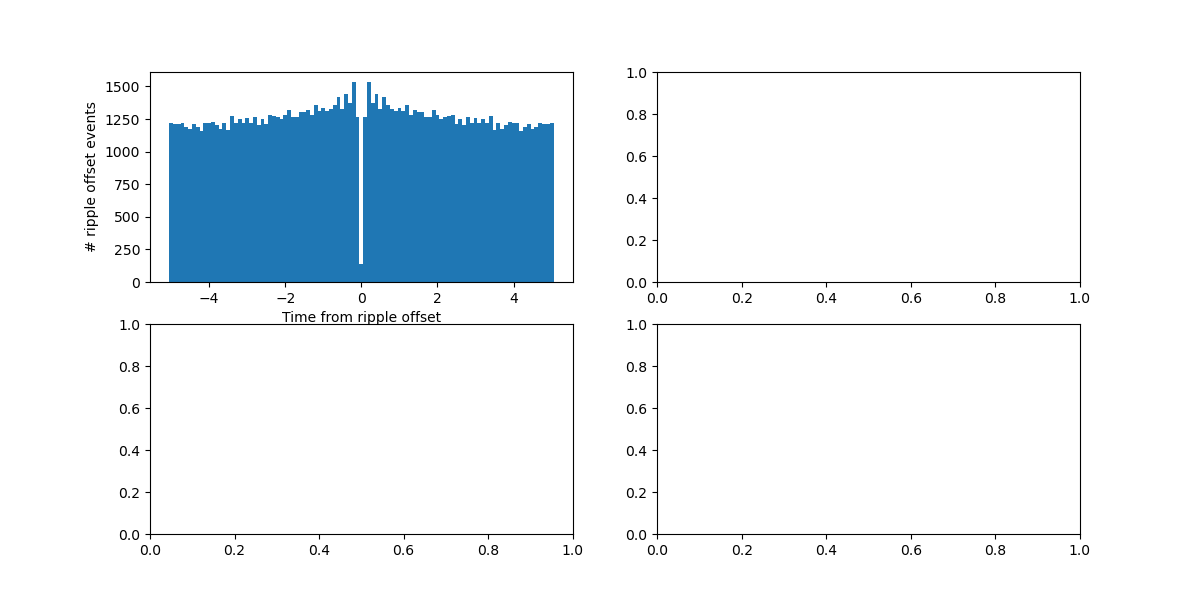

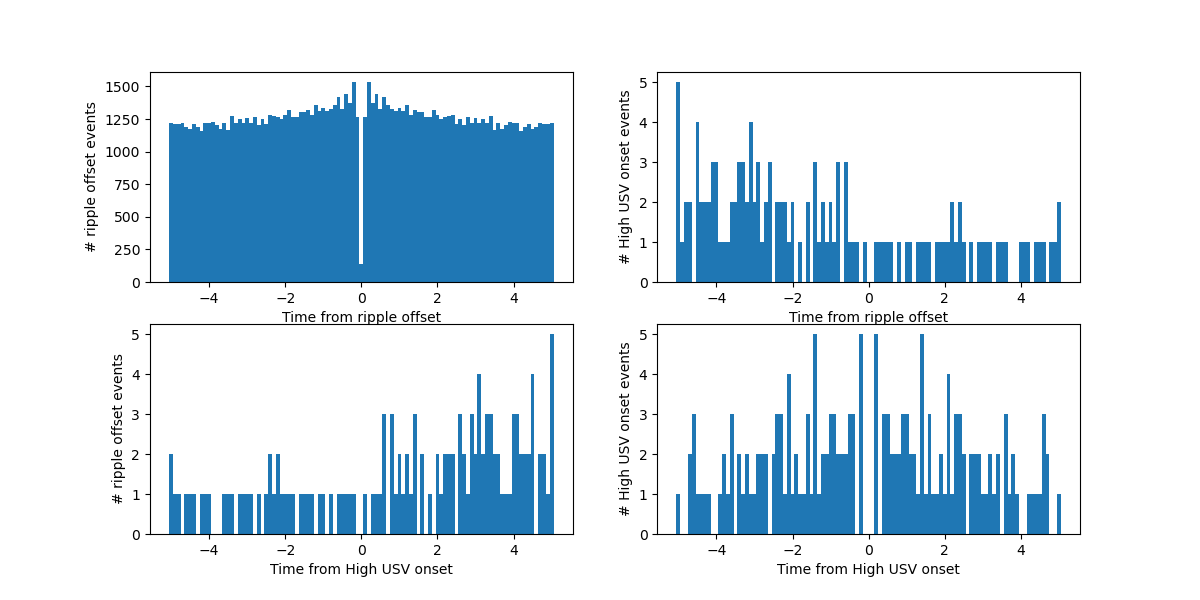

In [30]:
from neuropy.utils.ccg import correlograms

# We observe that right after ripple ends there seem to be a lot of USVs starting - check this by looking at CCG between ripple off and
# USV onset times
ripple_off_usv_on_times = [ripple_epochs.stops, usv_epochs.starts]
ripple_off_usv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_usv_on_times)])
ripple_off_usv_on_times = np.hstack(ripple_off_usv_on_times)
sort_ids = np.argsort(ripple_off_usv_on_times)

ripple_off_usv_on_times = ripple_off_usv_on_times[sort_ids]
ripple_off_usv_on_ids = ripple_off_usv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_usv_on_times, ripple_off_usv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr4_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['ripple offset', 'USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
corr4_fig.savefig('/home/bowenw/Documents/thesisplots/Jyn usv-ripple ccg all.png')

#low usv
from neuropy.utils.ccg import correlograms

# We observe that right after ripple ends there seem to be a lot of USVs starting - check this by looking at CCG between ripple off and
# USV onset times
ripple_off_lowusv_on_times = [ripple_epochs.stops, lowusv_epochs.start]
ripple_off_lowusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_lowusv_on_times)])
ripple_off_lowusv_on_times = np.hstack(ripple_off_lowusv_on_times)
sort_ids = np.argsort(ripple_off_lowusv_on_times)

ripple_off_lowusv_on_times = ripple_off_lowusv_on_times[sort_ids]
ripple_off_lowusv_on_ids = ripple_off_lowusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_lowusv_on_times, ripple_off_lowusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr5_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['ripple offset', 'Low USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
corr5_fig.savefig('/home/bowenw/Documents/thesisplots/Jyn usv-ripple ccg lowusv.png')

#high usv
from neuropy.utils.ccg import correlograms

# We observe that right after ripple ends there seem to be a lot of USVs starting - check this by looking at CCG between ripple off and
# USV onset times
ripple_off_highusv_on_times = [ripple_epochs.stops, highusv_epochs.start]
ripple_off_highusv_on_ids = np.hstack([np.ones_like(array)*ida for ida, array in enumerate(ripple_off_highusv_on_times)])
ripple_off_highusv_on_times = np.hstack(ripple_off_highusv_on_times)
sort_ids = np.argsort(ripple_off_highusv_on_times)

ripple_off_highusv_on_times = ripple_off_highusv_on_times[sort_ids]
ripple_off_highusv_on_ids = ripple_off_highusv_on_ids[sort_ids].astype(int)

window_size = 10 # seconds
bin_size = 0.1 # seconds
ccg = correlograms(ripple_off_highusv_on_times, ripple_off_highusv_on_ids, sample_rate=30, window_size=window_size, bin_size=bin_size)
# Sample plotting code, low_usv
time_bins = np.linspace(-window_size/2, window_size/2, np.array(window_size/bin_size + 1, dtype=int))
corr6_fig, ax = plt.subplots(2, 2, figsize=(12, 6))

var_names = ['ripple offset', 'High USV onset']
for idv, (a, ccg_use) in enumerate(zip(ax, ccg)):
    for ida2, (a2, ccg_use2) in enumerate(zip(a, ccg_use)): 
        a2.bar(time_bins, ccg_use2, width=bin_size)
        a2.set_xlabel(f"Time from {var_names[idv]}")
        a2.set_ylabel(f"# {var_names[ida2]} events")
corr6_fig.savefig('/home/bowenw/Documents/thesisplots/Jyn usv-ripple ccg highusv.png')

In [31]:
signal.time_slice(t_start=usv_epochs.starts[0], t_stop=usv_epochs.stops[0])

In [32]:
theta_power_sg = core.signal.Signal(theta_power, signal.sampling_rate)

## USV and non USV theta power plots

In [33]:
recording_duration = 3000 
theta_power_usvs = []
theta_power_non_usvs = []

for i, usv_epoch in enumerate(usv_epochs):
    if usv_epoch.stops > recording_duration:

        usv_epoch.stops = recording_duration
    

    power_slice = theta_power_sg.time_slice(t_start=usv_epoch.starts, t_stop=min(usv_epoch.stops, recording_duration))
    theta_power_usvs.append(power_slice.traces[0].mean())


    next_start = usv_epochs[i+1].starts if i+1 < len(usv_epochs) else recording_duration

    if usv_epoch.stops < next_start and (next_start - usv_epoch.stops) > 1:
        power_slice = theta_power_sg.time_slice(t_start=usv_epoch.stops, t_stop=next_start)
        theta_power_non_usvs.append(power_slice.traces[0].mean())


theta_power_usvs = np.array(theta_power_usvs)
theta_power_non_usvs = np.array(theta_power_non_usvs)


df1 = pd.DataFrame({"Theta Power": theta_power_usvs, "Epoch": "USV"})
df2 = pd.DataFrame({"Theta Power": theta_power_non_usvs, "Epoch": "non-USV"})
theta_power_df = pd.concat([df1, df2], axis=0).reset_index(drop=True)

theta_power_df

,Theta Power,Epoch
0,-1.824405,USV
1,-1.057234,USV
2,-0.052633,USV
3,-0.354325,USV
4,-1.253050,USV
5,-0.700304,USV
6,-0.331680,USV
7,0.063630,USV
8,-0.459209,USV
9,-0.158697,USV


In [34]:
theta_power_usvs

array([-1.82440544, -1.05723385, -0.05263275, -0.35432538, -1.25305002,
       -0.70030444, -0.33168016,  0.06363018, -0.4592088 , -0.15869668,
        0.3182506 , -0.52197792, -0.66031217, -0.47927721, -0.17160393,
        0.43995564])

<Axes: title={'center': 'Jyn: Theta power during usv and non_usv\nMean USV: -0.45, Mean non-USV: 0.04'}, xlabel='Epoch', ylabel='Theta Power'>

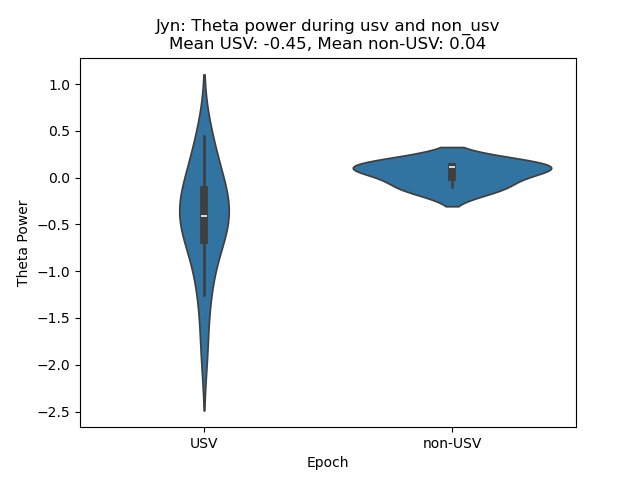

In [35]:
# Easily plot with seaborn
_, ax = plt.subplots()
title_text = f"Jyn: Theta power during usv and non_usv\nMean USV: {theta_power_usvs.mean():.2f}, Mean non-USV: {theta_power_non_usvs.mean():.2f}"
ax.set_title(title_text)
sns.violinplot(data=theta_power_df, x="Epoch", y="Theta Power")

## Read in frz data

In [36]:
import neuropy.io.dlcio as dlcio
dlc_path = '/data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training'
arena_side_pix = 60  # Keep this
arena_side_cm = 25.4  # Update this after measuring!!!
pix2cm = arena_side_cm / arena_side_pix

# Read in DLC data
sess.dlc = dlcio.DLC(dlc_path, pix2cm=pix2cm)

# Smooth position, get timestamps, and get speed
sess.dlc.get_timestamps('ms_webcam', include_str="2_training")
sess.dlc.smooth_pos(bodyparts=["crown_middle", "back_middle"])
sess.dlc.timestamps["Timestamps"] = sess.dlc.timestamps["Timestamps"].dt.tz_localize("America/Detroit")
sess.dlc.get_all_speed()

Using tracking file #1: /data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/2_training/training/Jyn/gobears/2022_06_17/12_00_02/My_WebCam/Jyn_training_combined_movieDLC_resnet50_TraceFC_shockboxFeb28shuffle1_500000.h5


,back_middle,crown_middle,left_ear,neck_base,nose,right_ear,tail_base,tail_end,tail_middle
0,NaN,NaN,0.769831,1.935070,1.447852,2.398943,1630.949087,1377.072127,1340.004069
1,NaN,NaN,2.103007,0.933486,2.071056,4.012287,9.392645,4.245449,2072.053602
2,NaN,NaN,2.956544,3.245430,0.682751,5.340966,6.610737,3.439799,6.799220
3,NaN,NaN,3.009256,5.869671,1.125576,3.365958,1913.425353,2.651677,2.805702
4,NaN,NaN,2.266452,3.144328,0.641712,5.352335,1.119085,1.825762,0.211167
...,...,...,...,...,...,...,...,...,...
50092,NaN,NaN,1.843074,1.865239,1.767862,3.396596,5.117078,1.795202,2.705018
50093,NaN,NaN,3.226239,3.227691,2.081879,2.493561,4.535563,0.941303,5.806985
50094,NaN,NaN,2.940200,3.249997,0.960036,3.365971,3.267952,1.728327,5.692416
50095,NaN,NaN,2.209908,3.601523,1.963645,4.047442,2.463565,2.122795,2.021413


In [37]:
# Load in openephys times to sync
import neuropy.io.openephysio as oeio
sync_df = oeio.create_sync_df(sess.basepath)
sync_df["Total seconds from start"] = (sync_df["Datetime"] - sync_df["Datetime"][0]).dt.total_seconds()

# sync DLC times to your eeg file
sess.dlc.timestamps["Total seconds from OE start"] = (sess.dlc.timestamps["Timestamps"] - sync_df["Datetime"][0]).dt.total_seconds()
sess.dlc.timestamps["eeg_time"] = np.interp(sess.dlc.timestamps["Total seconds from OE start"], sync_df["Total seconds from start"], 
                                            sync_df["eeg_time"])
sess.dlc.timestamps

start time = 2022-06-17 11:49:35.167771-04:00
start time = 2022-06-17 11:59:21.708710-04:00
start time = 2022-06-17 12:36:31.859416-04:00
start time = 2022-06-17 15:27:42.768667-04:00
start time = 2022-06-17 12:36:31.859416-04:00
start time = 2022-06-17 13:00:21.503381-04:00
start time = 2022-06-17 13:41:54.130737-04:00
start time = 2022-06-17 13:54:57.288518-04:00
start time = 2022-06-17 14:01:14.359765-04:00
start time = 2022-06-17 14:04:58.639594-04:00
start time = 2022-06-17 14:26:31.373293-04:00
start time = 2022-06-17 14:35:21.609805-04:00
start time = 2022-06-17 14:35:21.609805-04:00
start time = 2022-06-17 14:35:21.609805-04:00
start time = 2022-06-17 15:19:01.281248-04:00


,Frame Number,Time Stamp (ms),Buffer Index,Timestamps,Total seconds from OE start,eeg_time
0,0,-15,0,2022-06-17 12:00:02.842000-04:00,627.674229,472.681275
1,1,33,0,2022-06-17 12:00:02.890000-04:00,627.722229,472.729275
2,2,64,0,2022-06-17 12:00:02.921000-04:00,627.753229,472.760275
3,3,113,0,2022-06-17 12:00:02.970000-04:00,627.802229,472.809275
4,4,154,0,2022-06-17 12:00:03.011000-04:00,627.843229,472.850275
...,...,...,...,...,...,...
50092,50092,2094768,0,2022-06-17 12:34:57.625000-04:00,2722.457229,2567.463529
50093,50093,2094808,0,2022-06-17 12:34:57.665000-04:00,2722.497229,2567.503529
50094,50094,2094856,0,2022-06-17 12:34:57.713000-04:00,2722.545229,2567.551529
50095,50095,2094895,0,2022-06-17 12:34:57.752000-04:00,2722.584229,2567.590529


In [38]:
# Last calculate freezing times and plot again to check
frz_thresh = 0.25 # cm/sec  Adjust this to something that looks reasonable!
duration_thresh = 2 # sec, must be below the threshold above for at least that long to be considered freezing
bodypart_use = "crown_middle"
frz_bool = sess.dlc.speed[bodypart_use] < frz_thresh
frz_epochs = Epoch.from_boolean_array(frz_bool, t=sess.dlc.timestamps["eeg_time"])
frz_df = frz_epochs.to_dataframe()
frz_df = frz_df[frz_epochs.durations > duration_thresh]

frz_epochs = Epoch(frz_df)
frz_epochs

128 epochs
Snippet: 
         start        stop  duration label
0  796.727160  798.951159  2.223999  high
1  801.831158  804.055157  2.223999  high
2  845.239143  848.343141  3.103999  high
3  848.663141  850.727141  2.063999  high
4  877.143131  880.079130  2.935999  high

## moving speed during highusv/lowusv/frz

In [39]:
# moving speed during frz
mean_speeds_during_freezing = []
for start, end in zip(frz_epochs.starts, frz_epochs.stops):
    epoch_speeds = sess.dlc.speed[bodypart_use][(sess.dlc.timestamps["eeg_time"] >= start) & (sess.dlc.timestamps["eeg_time"] <= end)]
    mean_speed = epoch_speeds.mean()
    mean_speeds_during_freezing.append(mean_speed)

mean_speeds_during_freezing

[0.12222498477968541,
 0.0962200804696761,
 0.11647964918456763,
 0.10874028128388068,
 0.07713860283239025,
 0.06961082803219751,
 0.06477491133848995,
 0.10097299862121056,
 0.08307952759843486,
 0.08720264943442875,
 0.11622570712113639,
 0.07592851331422888,
 0.08901950183391638,
 0.1188735554233613,
 0.09493249723267069,
 0.10490664133450579,
 0.07754336064190548,
 0.09596670855478197,
 0.07304799694292473,
 0.083756751480573,
 0.1207494212850629,
 0.0869803990685955,
 0.11487777441669329,
 0.08050821341215425,
 0.10141463002822083,
 0.0898323895765062,
 0.09152726795277316,
 0.09954249647160235,
 0.09792166281041177,
 0.09047551142394442,
 0.10080822790622794,
 0.08349504571626096,
 0.09176447197085291,
 0.10242572645113074,
 0.10676392081313103,
 0.0995477136166408,
 0.07837332977264251,
 0.0861959666741139,
 0.12013213728338161,
 0.10265341363945278,
 0.07039986980028518,
 0.0841311144542648,
 0.08240639373260607,
 0.06457966582353425,
 0.08629753512727542,
 0.07304400060967985

In [40]:
# Moving speed during high USVs
mean_speeds_during_highusv = []
for start, end in zip(highusv_epochs['start'], highusv_epochs['stop']):
    epoch_speeds = sess.dlc.speed[bodypart_use][(sess.dlc.timestamps["eeg_time"] >= start) & (sess.dlc.timestamps["eeg_time"] <= end)]
    mean_speed = epoch_speeds.mean()
    mean_speeds_during_highusv.append(mean_speed)

mean_speeds_during_highusv


[37.487552682648236,
 1.5874462576111603,
 0.5967787344624068,
 0.7396463756574302,
 4.208343579275362,
 2.2333887512663324,
 0.3404625336933109,
 0.5741221617853364,
 nan,
 0.5678191456548944,
 0.05389206664115445,
 0.2823648339720419,
 0.0670510900017974,
 0.08616771522309924,
 0.044865194527564725,
 0.22664741959299325]

## theta power during USV/nonUSV/frz

In [42]:
theta_power_frz = []
theta_power_sg = core.signal.Signal(theta_power, signal.sampling_rate)
for frz_epoch in frz_epochs:

    power_slice = theta_power_sg.time_slice(t_start=frz_epoch.starts, t_stop=frz_epoch.stops)
    theta_power_frz.append(power_slice.traces[0].mean())

theta_power_frz = np.array(theta_power_frz)

frz_df = pd.DataFrame({"Theta Power": theta_power_frz, "Epoch": "Freezing"})
theta_power_df = pd.concat((df1, df2, frz_df), axis=0).reset_index()

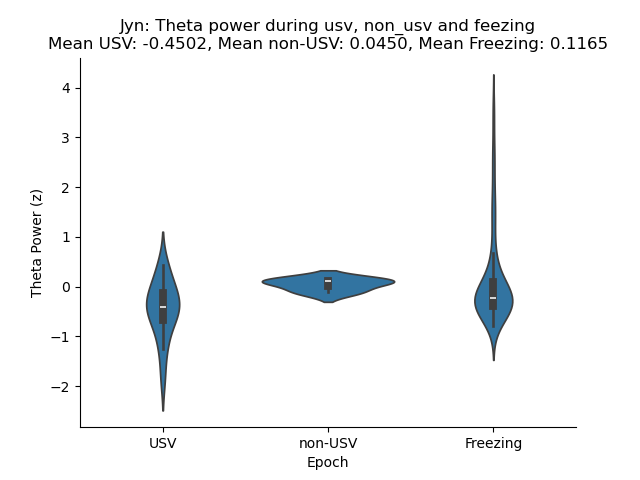

In [43]:
# Easily plot with seaborn
vio1, ax = plt.subplots()

title_text = f"Jyn: Theta power during usv, non_usv and feezing\nMean USV: {theta_power_usvs.mean():.4f}, Mean non-USV: {theta_power_non_usvs.mean():.4f}, Mean Freezing: {theta_power_frz.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=theta_power_df, x="Epoch", y="Theta Power")
ax.set_ylabel("Theta Power (z)")
sns.despine(ax=ax)
vio1.savefig('/home/bowenw/Documents/thesisplots/Jyn usv nonusv thetapower violinplot.png')

In [44]:
import pingouin as pg
pg.pairwise_tests(data=theta_power_df, dv="Theta Power", between="Epoch", padjust="bonf")

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Epoch,Freezing,USV,False,True,3.427056,25.484765,two-sided,0.002080,0.006240,bonf,35.56,0.639249
1,Epoch,Freezing,non-USV,False,True,0.655856,9.495446,two-sided,0.527487,1.000000,bonf,0.535,0.078580
2,Epoch,USV,non-USV,False,True,-3.056853,15.829478,two-sided,0.007604,0.022811,bonf,5.942,-0.868937


In [45]:
theta_power_usvs

array([-1.82440544, -1.05723385, -0.05263275, -0.35432538, -1.25305002,
       -0.70030444, -0.33168016,  0.06363018, -0.4592088 , -0.15869668,
        0.3182506 , -0.52197792, -0.66031217, -0.47927721, -0.17160393,
        0.43995564])

In [46]:
theta_power_non_usvs

array([ 0.12281959, -0.10169067,  0.11386875])

In [47]:
theta_power_frz

array([-0.25218655,  3.57412198, -0.2190559 ,  1.30997812, -0.20351679,
       -0.37646407,  0.08656761, -0.40664896, -0.39891852, -0.30716809,
       -0.22898423,  3.25640839,  0.56090658,  2.53871391, -0.10224722,
        0.33796596,  0.46300477,  0.5382969 ,  1.42204074, -0.02235101,
       -0.78291791, -0.35128951, -0.20651219, -0.46556576, -0.4837917 ,
        1.50720012,  0.99337127,  0.15700319, -0.47214955, -0.50215508,
       -0.34764778, -0.59135288,  2.25131304,  0.06285386,  2.73895159,
        0.40747347,  0.29234013,  1.20279658, -0.41081002, -0.40978763,
       -0.09110428,  0.03403577,  1.9737763 ,  1.76261388, -0.5152132 ,
       -0.31159842, -0.53432174,  0.83891896, -0.49217387, -0.45244857,
       -0.46532247, -0.50007305, -0.28200556, -0.13802955,  0.00621533,
       -0.26232102, -0.19084735, -0.25556669, -0.24162555, -0.40109669,
       -0.28961912, -0.30652876,  0.23908374,  0.00480071,  1.62312185,
       -0.26111476,  0.10173972,  2.46673596,  0.53958589,  0.67

## Theta power during USV/freezing/USV during freezing/USV during non-frz

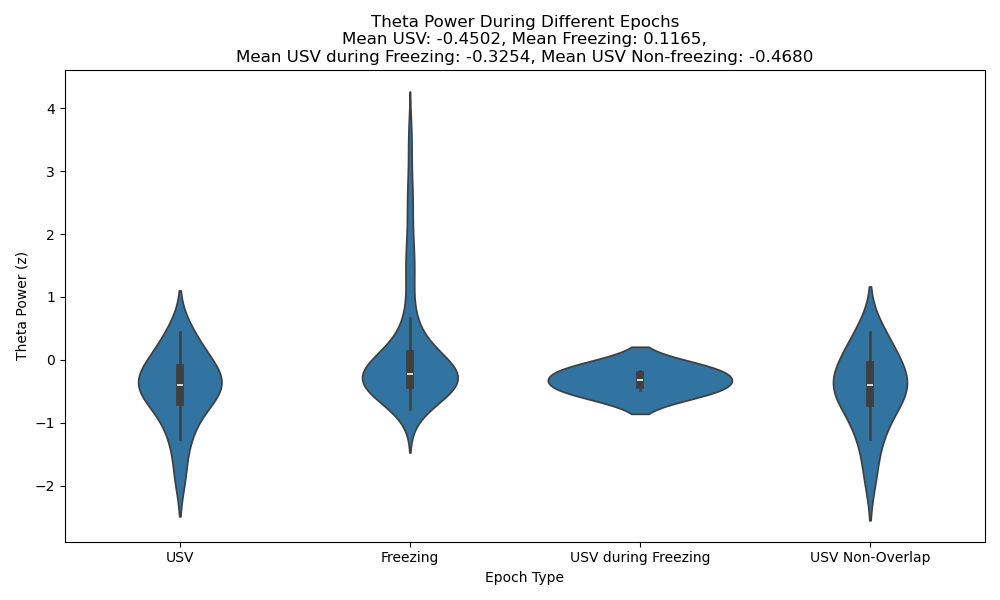

In [48]:
def categorize_usvs(usv_df, frz_df):
    usvs_during_freezing = []
    usvs_non_overlap = []
    for index, usv in usv_df.iterrows():
        overlap = False
        for _, frz in frz_df.iterrows():
            if (usv['start'] < frz['stop']) and (usv['stop'] > frz['start']):
                overlap = True
                usvs_during_freezing.append(usv)
                break
        if not overlap:
            usvs_non_overlap.append(usv)
    return pd.DataFrame(usvs_during_freezing), pd.DataFrame(usvs_non_overlap)

# Calculate the mean theta power for a given epoch type
def calculate_theta_power(signal, epochs_df):
    theta_power_values = []
    for _, epoch in epochs_df.iterrows():
        power_slice = signal.time_slice(t_start=epoch['start'], t_stop=epoch['stop'])
        theta_power_values.append(power_slice.traces[0].mean())
    return np.array(theta_power_values)

# Convert Epoch objects to DataFrames
usv_df = usv_epochs.to_dataframe()
frz_df = frz_epochs.to_dataframe()

# Categorize USVs
usv_during_freezing_df, usv_non_overlap_df = categorize_usvs(usv_df, frz_df)

# Assuming theta_power_sg is already correctly instantiated:
# Calculate theta power for each epoch type
theta_power_usv = calculate_theta_power(theta_power_sg, usv_df)
theta_power_frz = calculate_theta_power(theta_power_sg, frz_df)
theta_power_usv_during_freezing = calculate_theta_power(theta_power_sg, usv_during_freezing_df)
theta_power_usv_non_overlap = calculate_theta_power(theta_power_sg, usv_non_overlap_df)

# Create DataFrame for plotting
df_usv = pd.DataFrame({"Theta Power": theta_power_usv, "Epoch": "USV"})
df_frz = pd.DataFrame({"Theta Power": theta_power_frz, "Epoch": "Freezing"})
df_usv_during_freezing = pd.DataFrame({"Theta Power": theta_power_usv_during_freezing, "Epoch": "USV during Freezing"})
df_usv_non_overlap = pd.DataFrame({"Theta Power": theta_power_usv_non_overlap, "Epoch": "USV Non-Overlap"})

theta_power_df = pd.concat([df_usv, df_frz, df_usv_during_freezing, df_usv_non_overlap]).reset_index(drop=True)

mean_theta_power_usv = theta_power_usv.mean()
mean_theta_power_frz = theta_power_frz.mean()
mean_theta_power_usv_during_freezing = theta_power_usv_during_freezing.mean()
mean_theta_power_usv_non_freezing = theta_power_usv_non_overlap.mean()



title_text = (
    f"Theta Power During Different Epochs\n"
    f"Mean USV: {mean_theta_power_usv:.4f}, "
    f"Mean Freezing: {mean_theta_power_frz:.4f},\n"
    f"Mean USV during Freezing: {mean_theta_power_usv_during_freezing:.4f}, "
    f"Mean USV Non-freezing: {mean_theta_power_usv_non_freezing:.4f}"
)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(data=theta_power_df, x="Epoch", y="Theta Power")
plt.title(title_text)
plt.xlabel("Epoch Type")
plt.ylabel("Theta Power (z)")
plt.tight_layout()
plt.show()

In [49]:
usv_df

,start,stop,Begin_Time,Freq_Min,Duration,Freq_Range,Score,Accept,label,duration
0,870.126212,870.171338,505.926529,47.944444,0.045134,27.777778,1.000000,1,,0.045126
1,871.160586,871.233890,506.961084,45.345779,0.073317,25.343152,1.000000,1,,0.073304
2,871.556279,871.597182,507.356846,50.209416,0.040911,5.905844,1.000000,1,,0.040904
3,871.961179,872.056770,507.761818,46.842283,0.095608,5.095238,1.000000,1,,0.095591
4,872.405570,872.475605,508.206287,45.924784,0.070048,5.326840,1.000000,1,,0.070036
5,872.623204,872.696609,508.423960,42.557651,0.073417,27.213203,1.000000,1,,0.073404
6,873.303583,873.349983,509.104458,38.860931,0.046408,29.645022,1.000000,1,,0.046400
7,873.580485,873.676931,509.381408,42.366841,0.096464,7.597611,0.544231,1,,0.096447
8,873.851948,873.887906,509.652919,37.355519,0.035965,29.521707,1.000000,1,,0.035958
9,874.088381,874.238507,509.889394,43.608766,0.150152,8.221861,0.544231,1,,0.150126


In [50]:
frz_df

,start,stop,duration,label
0,796.727160,798.951159,2.223999,high
1,801.831158,804.055157,2.223999,high
2,845.239143,848.343141,3.103999,high
3,848.663141,850.727141,2.063999,high
4,877.143131,880.079130,2.935999,high
...,...,...,...,...
123,2525.759543,2529.327542,3.567999,high
124,2530.864542,2535.472540,4.607998,high
125,2535.631540,2538.111539,2.479999,high
126,2555.119533,2558.095532,2.975999,high


In [51]:
theta_power_non_usvs

array([ 0.12281959, -0.10169067,  0.11386875])

# SWR power

In [52]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 18
thresh = (2, None)  # conservative but good
edge_cutoff = 0.5
exclude_theta_epochs = False  # make this true if you end up with a lot of false positive ripples as gamma events during theta

if not exclude_theta_epochs:
    ripple_epochs, ripple_power = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    ripple_epochs, ripple_power = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                         edge_cutoff=edge_cutoff,
                                         ignore_epochs=art_epochs.__add__(theta_epochs), return_power=True)
sess.recinfo.write_epochs(ripple_epochs, ext='swr')
ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
ripple_epochs.save(ripple_epochs_file)

Selected channels for ripples: [18]
9030 epochs remaining with durations within (0.05,0.45)
/data2/Trace_FC/Recording_Rats/Jyn/2022_06_17_training/Jyn_training_denoised.ripple_epochs.npy saved


In [53]:
ripple_power_sg = core.signal.Signal(ripple_power, signal.sampling_rate)

In [54]:
recording_duration = 3000 
ripple_power_usvs = []
ripple_power_non_usvs = []

for i, usv_epoch in enumerate(usv_epochs):
    if usv_epoch.stops > recording_duration:
        usv_epoch.stops = recording_duration
    
    power_slice = ripple_power_sg.time_slice(t_start=usv_epoch.starts, t_stop=min(usv_epoch.stops, recording_duration))
    ripple_power_usvs.append(power_slice.traces[0].mean())

    next_start = usv_epochs[i+1].starts if i+1 < len(usv_epochs) else recording_duration

    if usv_epoch.stops < next_start and (next_start - usv_epoch.stops) > 1:
        power_slice = ripple_power_sg.time_slice(t_start=usv_epoch.stops, t_stop=next_start)
        ripple_power_non_usvs.append(power_slice.traces[0].mean())


ripple_power_usvs = np.array(ripple_power_usvs)
ripple_power_non_usvs = [x for x in ripple_power_non_usvs if not np.isnan(x)]
ripple_power_non_usvs = np.array(ripple_power_non_usvs)


df1 = pd.DataFrame({"ripple Power": ripple_power_usvs, "Epoch": "USV"})
df2 = pd.DataFrame({"ripple Power": ripple_power_non_usvs, "Epoch": "non-USV"})
ripple_power_df = pd.concat([df1, df2], axis=0).reset_index(drop=True)

ripple_power_df

,ripple Power,Epoch
0,-2.845596,USV
1,3.149658,USV
2,2.895683,USV
3,1.598655,USV
4,3.620296,USV
5,2.207884,USV
6,3.871088,USV
7,3.081512,USV
8,2.914606,USV
9,2.051453,USV


<Axes: title={'center': 'Jyn: ripple power during usv and non_usv\nMean USV: 2.3796, Mean non-USV: 1.3603'}, xlabel='Epoch', ylabel='ripple Power'>

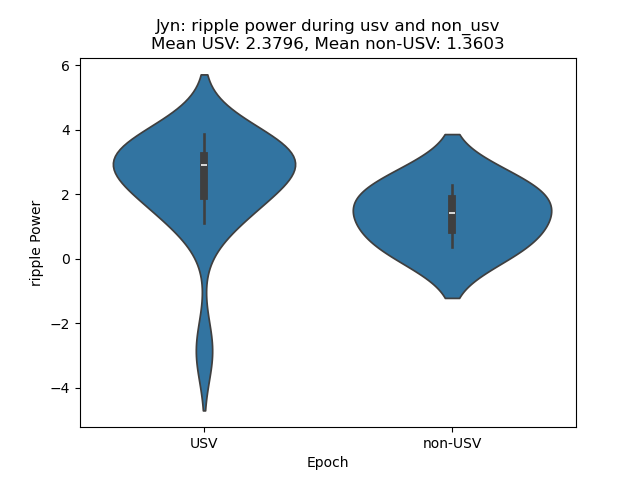

In [55]:
# Easily plot with seaborn
_, ax = plt.subplots()
title_text = f"Jyn: ripple power during usv and non_usv\nMean USV: {ripple_power_usvs.mean():.4f}, Mean non-USV: {ripple_power_non_usvs.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=ripple_power_df, x="Epoch", y="ripple Power")

## ripple power during USV/nonUSV/Freezing

In [56]:
ripple_power_frz = []
ripple_power_sg = core.signal.Signal(ripple_power, signal.sampling_rate)
for frz_epoch in frz_epochs:

    power_slice = ripple_power_sg.time_slice(t_start=frz_epoch.starts, t_stop=frz_epoch.stops)
    ripple_power_frz.append(power_slice.traces[0].mean())

ripple_power_frz = np.array(ripple_power_frz)

frz_df = pd.DataFrame({"ripple Power": ripple_power_frz, "Epoch": "Freezing"})
ripple_power_df = pd.concat((df1, df2, frz_df), axis=0).reset_index()

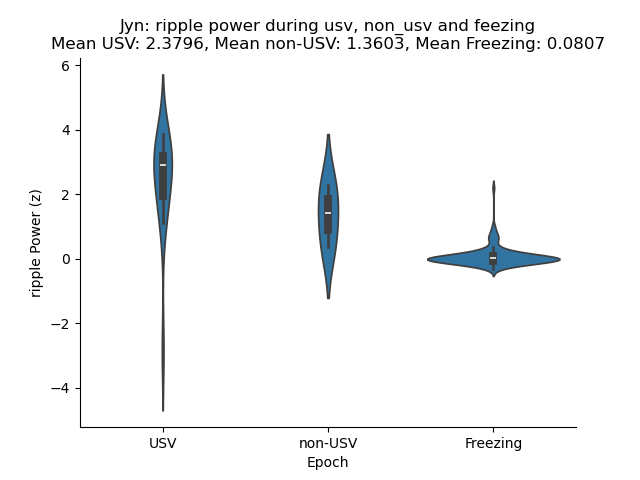

In [57]:
# Easily plot with seaborn
vio1j, ax = plt.subplots()

title_text = f"Jyn: ripple power during usv, non_usv and feezing\nMean USV: {ripple_power_usvs.mean():.4f}, Mean non-USV: {ripple_power_non_usvs.mean():.4f}, Mean Freezing: {ripple_power_frz.mean():.4f}"
ax.set_title(title_text)
sns.violinplot(data=ripple_power_df, x="Epoch", y="ripple Power")
ax.set_ylabel("ripple Power (z)")
sns.despine(ax=ax)
vio1j.savefig('/home/bowenw/Documents/thesisplots/Jyn usv nonusv ripplepower violinplot.png')

In [58]:
import pingouin as pg
pg.pairwise_tests(data=ripple_power_df, dv="ripple Power", between="Epoch", padjust="bonf")

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,Epoch,Freezing,USV,False,True,-5.699967,15.129886,two-sided,0.000041,0.000122,bonf,1.431e+05,-3.844101
1,Epoch,Freezing,non-USV,False,True,-2.271026,2.008848,two-sided,0.150576,0.451727,bonf,2.457,-3.965149
2,Epoch,USV,non-USV,False,True,1.473181,4.414214,two-sided,0.208179,0.624537,bonf,0.921,0.628710


## ripple power during USV/frz/USV during frz/USV during nonfrz

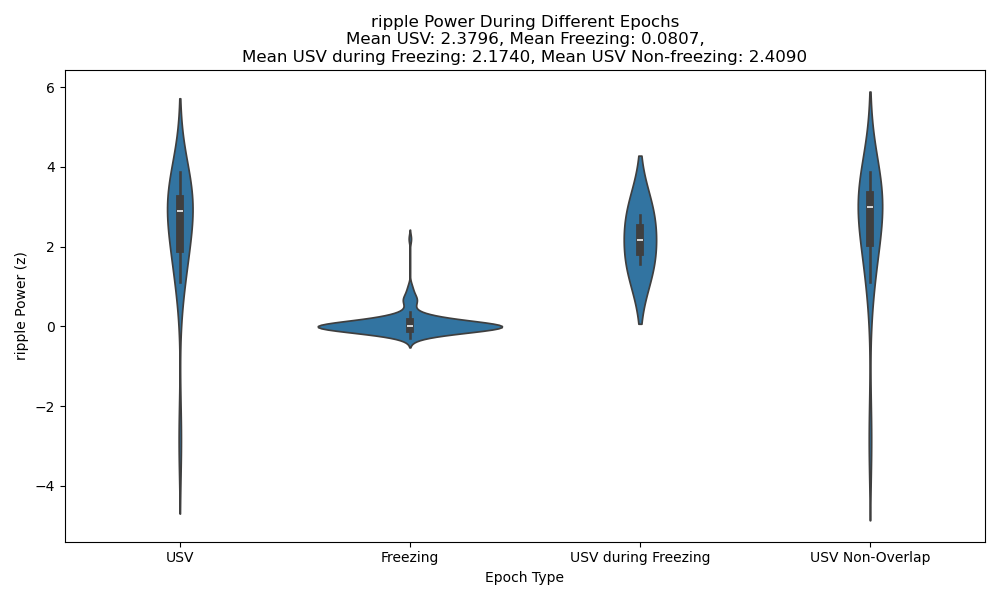

In [59]:
def categorize_usvs(usv_df, frz_df):
    usvs_during_freezing = []
    usvs_non_overlap = []
    for index, usv in usv_df.iterrows():
        overlap = False
        for _, frz in frz_df.iterrows():
            if (usv['start'] < frz['stop']) and (usv['stop'] > frz['start']):
                overlap = True
                usvs_during_freezing.append(usv)
                break
        if not overlap:
            usvs_non_overlap.append(usv)
    return pd.DataFrame(usvs_during_freezing), pd.DataFrame(usvs_non_overlap)

# Calculate the mean ripple power for a given epoch type
def calculate_ripple_power(signal, epochs_df):
    ripple_power_values = []
    for _, epoch in epochs_df.iterrows():
        power_slice = signal.time_slice(t_start=epoch['start'], t_stop=epoch['stop'])
        ripple_power_values.append(power_slice.traces[0].mean())
    return np.array(ripple_power_values)

# Convert Epoch objects to DataFrames
usv_df = usv_epochs.to_dataframe()
frz_df = frz_epochs.to_dataframe()

# Categorize USVs
usv_during_freezing_df, usv_non_overlap_df = categorize_usvs(usv_df, frz_df)

# Assuming ripple_power_sg is already correctly instantiated:
# Calculate ripple power for each epoch type
ripple_power_usv = calculate_ripple_power(ripple_power_sg, usv_df)
ripple_power_frz = calculate_ripple_power(ripple_power_sg, frz_df)
ripple_power_usv_during_freezing = calculate_ripple_power(ripple_power_sg, usv_during_freezing_df)
ripple_power_usv_non_overlap = calculate_ripple_power(ripple_power_sg, usv_non_overlap_df)

# Create DataFrame for plotting
df_usv = pd.DataFrame({"ripple Power": ripple_power_usv, "Epoch": "USV"})
df_frz = pd.DataFrame({"ripple Power": ripple_power_frz, "Epoch": "Freezing"})
df_usv_during_freezing = pd.DataFrame({"ripple Power": ripple_power_usv_during_freezing, "Epoch": "USV during Freezing"})
df_usv_non_overlap = pd.DataFrame({"ripple Power": ripple_power_usv_non_overlap, "Epoch": "USV Non-Overlap"})

ripple_power_df = pd.concat([df_usv, df_frz, df_usv_during_freezing, df_usv_non_overlap]).reset_index(drop=True)

mean_ripple_power_usv = ripple_power_usv.mean()
mean_ripple_power_frz = ripple_power_frz.mean()
mean_ripple_power_usv_during_freezing = ripple_power_usv_during_freezing.mean()
mean_ripple_power_usv_non_freezing = ripple_power_usv_non_overlap.mean()



title_text = (
    f"ripple Power During Different Epochs\n"
    f"Mean USV: {mean_ripple_power_usv:.4f}, "
    f"Mean Freezing: {mean_ripple_power_frz:.4f},\n"
    f"Mean USV during Freezing: {mean_ripple_power_usv_during_freezing:.4f}, "
    f"Mean USV Non-freezing: {mean_ripple_power_usv_non_freezing:.4f}"
)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.violinplot(data=ripple_power_df, x="Epoch", y="ripple Power")
plt.title(title_text)
plt.xlabel("Epoch Type")
plt.ylabel("ripple Power (z)")
plt.tight_layout()
plt.show()

In [60]:
ripple_power_usv_during_freezing

array([2.78296743, 1.56508588])

In [61]:
ripple_power_non_usvs

array([2.30450916, 1.41897339, 0.35745239])

In [62]:
ripple_power_frz

array([-3.05273280e-03, -4.63476520e-02, -3.28026826e-02, -7.74793565e-02,
        2.19878862e+00,  8.32702782e-01,  8.58016537e-02, -2.50138647e-02,
        2.08840287e-02,  6.35059496e-02,  1.89814595e-01, -1.93015546e-02,
       -1.57457256e-01,  3.29527724e-02,  9.40401146e-02, -1.02232516e-01,
        2.34019612e-02,  3.54959082e-02, -3.45050161e-02,  4.53829192e-03,
        2.08286269e-02, -2.26008450e-03,  3.14404187e-02,  1.60635021e-02,
       -1.27105924e-01, -4.73104953e-02, -1.12330901e-01, -7.32332788e-03,
        2.29531066e-02,  1.74578239e-02, -1.06472951e-01, -4.72128761e-04,
       -3.33166836e-02, -5.96040623e-02, -1.13696750e-01, -1.98225711e-01,
        7.71045778e-02,  8.88281596e-02, -9.87532688e-02,  7.36427037e-02,
        2.82739538e-01,  1.84014956e-01,  1.83030054e-01,  1.41871702e-01,
        7.60839992e-02,  3.17206792e-02,  2.20383029e-01,  4.08470795e-02,
       -1.54334261e-01, -8.27588956e-02, -3.00366143e-01, -1.19921990e-01,
       -7.46041558e-02, -